# Bài toán Delay Probability Prediction

## Import libraries and load the dataset

In [4]:
!pip install kagglehub

In [5]:
!pip install holidays

In [6]:
!pip install lightgbm

In [7]:
!pip install xgboost

In [8]:
!pip install boruta

In [2]:
# Imported Libraries
import kagglehub
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import holidays
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.cm as cm
import plotly.graph_objects as go

# Classifier Libraries
from sklearn.linear_model import LogisticRegression

# Other Libraries
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import *

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
# Download dữ liệu từ kagglehub
path = kagglehub.dataset_download("datasetengineer/logistics-and-supply-chain-dataset")
print(os.listdir(path))

['dynamic_supply_chain_logistics_dataset.csv']


In [5]:
# Đọc file CSV và print điểm dữ liệu mẫu 
csv_file = os.path.join(path, "dynamic_supply_chain_logistics_dataset.csv")
df = pd.read_csv(csv_file)
df.head()

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


**Giải thích**:

- **Timestamp**: The date and time when the data was recorded (hourly resolution).
- **Vehicle GPS Latitude**: The latitude coordinate indicating the location of the vehicle.
- **Vehicle GPS Longitude**: The longitude coordinate indicating the location of the vehicle.
- **Fuel Consumption Rate**: The rate of fuel consumption recorded for the vehicle in liters per hour.
- **ETA Variation (hours)**: The difference between the estimated and actual arrival times.
- **Traffic Congestion Level**: The level of traffic congestion affecting the logistics route (scale 0-10).
- **Warehouse Inventory Level**: The current inventory levels at the warehouse (units).
- **Loading/Unloading Time**: The time taken for loading or unloading operations in hours.
- **Handling Equipment Availability**: Availability status of equipment like forklifts (0 = unavailable, 1 = available).
- **Order Fulfillment Status**: Status indicating whether the order was fulfilled on time (0 = not fulfilled, 1 = fulfilled).
- **Weather Condition Severity**: The severity of weather conditions affecting operations (scale 0-1).
- **Port Congestion Level**: The level of congestion at the port (scale 0-10).
- **Shipping Costs**: The costs associated with the shipping operations in USD.
- **Supplier Reliability Score**: A score indicating the reliability of the supplier (scale 0-1).
- **Lead Time (days)**: The average time taken for a supplier to deliver materials.
- **Historical Demand**: The historical demand for logistics services (units).
- **IoT Temperature**: The temperature recorded by IoT sensors in degrees Celsius.
- **Cargo Condition Status**: Condition status of the cargo based on IoT monitoring (0 = poor, 1 = good).
- **Route Risk Level**: The risk level associated with a particular logistics route (scale 0-10).
- **Customs Clearance Time**: The time required to clear customs for shipments.
- **Driver Behavior Score**: An indicator of the driver's behavior based on driving patterns (scale 0-1).
- **Fatigue Monitoring Score**: A score indicating the level of driver fatigue (scale 0-1).

## Dataset Overview

In [8]:
# Drop một số target variables mà bài toán không cần dùng tới
df.columns = df.columns.str.strip()
df.drop(['risk_classification', 'disruption_likelihood_score', 'delivery_time_deviation'], axis=1, errors='ignore', inplace = True)
df.head()

,timestamp,vehicle_gps_latitude,vehicle_gps_longitude,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,...,supplier_reliability_score,lead_time_days,historical_demand,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,delay_probability
0,2021-01-01 00:00:00,40.375568,-77.014318,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,...,0.986064,2.128009,100.772854,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.885291
1,2021-01-01 01:00:00,33.507818,-117.036902,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,...,0.463233,12.608166,5313.738114,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.544178
2,2021-01-01 02:00:00,30.020640,-75.269224,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,...,0.598561,14.124452,1595.049146,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.803322
3,2021-01-01 03:00:00,36.649223,-70.190529,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,...,0.742735,3.818972,2530.431941,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.025977
4,2021-01-01 04:00:00,30.001279,-70.012195,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,...,0.431088,14.001491,2146.190197,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.991122


In [22]:
df.columns

Index(['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude',
       'fuel_consumption_rate', 'eta_variation_hours',
       'traffic_congestion_level', 'warehouse_inventory_level',
       'loading_unloading_time', 'handling_equipment_availability',
       'order_fulfillment_status', 'weather_condition_severity',
       'port_congestion_level', 'shipping_costs', 'supplier_reliability_score',
       'lead_time_days', 'historical_demand', 'iot_temperature',
       'cargo_condition_status', 'route_risk_level', 'customs_clearance_time',
       'driver_behavior_score', 'fatigue_monitoring_score',
       'delay_probability'],
      dtype='object')

In [38]:
# Kiểm tra shape của tập dữ liệu
df.shape

(32065, 23)

**Brief conclusion:** Dataset has 32065 data points and 23 fields.

In [41]:
# Một số thông tin cơ bản của các trường dữ liệu: dạng dữ liệu, ô dữ liệu có giá trị,...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        32065 non-null  object 
 1   vehicle_gps_latitude             32065 non-null  float64
 2   vehicle_gps_longitude            32065 non-null  float64
 3   fuel_consumption_rate            32065 non-null  float64
 4   eta_variation_hours              32065 non-null  float64
 5   traffic_congestion_level         32065 non-null  float64
 6   warehouse_inventory_level        32065 non-null  float64
 7   loading_unloading_time           32065 non-null  float64
 8   handling_equipment_availability  32065 non-null  float64
 9   order_fulfillment_status         32065 non-null  float64
 10  weather_condition_severity       32065 non-null  float64
 11  port_congestion_level            32065 non-null  float64
 12  shipping_costs    

**Brief conclusion:**

- Number of Entries: The dataset consists of 32065 entries, ranging from index 0 to 32065.
- Columns: There are 22 columns in the dataset corresponding to various attributes of the patients and results of tests.
- Data Types: Most of the columns (23 out of 25) are of the float64 data type, except for timestamp and risk_classification.
- Missing Values: There don't appear to be any missing values in the dataset as each column has 32065 non-null entries.

In [63]:
# Kiểm tra tập dữ liệu có duplicated row không
df.duplicated().sum()

0

**Brief conclusion:** Number of duplicated rows: There don't appear to be any duplicated rows in the dataset.

In [48]:
# Kiểm tra tập dữ liệu có bao nhiêu giá trị unique
summary = pd.DataFrame({
    'missing': df.isnull().sum(),
    'unique': df.nunique(),
    'total': df.shape[0]
})

summary['unique_pct'] = (summary['unique'] / summary['total'] * 100).round(2)

print(summary)

                                 missing  unique  total  unique_pct
timestamp                              0   32065  32065      100.00
vehicle_gps_latitude                   0   32065  32065      100.00
vehicle_gps_longitude                  0   32065  32065      100.00
fuel_consumption_rate                  0   32037  32065       99.91
eta_variation_hours                    0   32065  32065      100.00
traffic_congestion_level               0   32065  32065      100.00
warehouse_inventory_level              0   32065  32065      100.00
loading_unloading_time                 0   32065  32065      100.00
handling_equipment_availability        0   32065  32065      100.00
order_fulfillment_status               0   32065  32065      100.00
weather_condition_severity             0   32065  32065      100.00
port_congestion_level                  0   32065  32065      100.00
shipping_costs                         0   32065  32065      100.00
supplier_reliability_score             0   32065

**Brief conclusion:** All fields have more than 99% unique data values, it's understandable as measurement variables often in float format. During data transformation, some processing steps can be applied, such as rounding values or using binning to reduce dispersion and gain an overall understanding of the data fields.

In [10]:
# Đánh giá phân bổ của các trường thông tin dạng float 
float_df = df.select_dtypes(include=['float64'])
stats = float_df.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99]).transpose().assign(
    cv=lambda x: 100.00 * x['std'] / x['mean']
)
stats

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max,cv
vehicle_gps_latitude,32065.0,38.023589,6.917909,3.000000e+01,31.280550,36.413820,44.453655,48.698604,49.606658,49.971725,50.000000,18.193730
vehicle_gps_longitude,32065.0,-90.116648,17.369244,-1.200000e+02,-106.253913,-86.293414,-73.079367,-70.318129,-70.055658,-70.001053,-70.000000,-19.274179
fuel_consumption_rate,32065.0,8.011735,4.264960,5.000000e+00,5.019984,5.636036,9.669944,15.676118,18.042072,19.737362,19.999875,53.233914
eta_variation_hours,32065.0,2.893068,2.274044,-1.999993e+00,1.185744,3.882059,4.884355,4.994520,4.999430,4.999997,5.000000,78.603197
traffic_congestion_level,32065.0,4.991493,3.532048,1.091633e-09,1.474720,4.981244,8.534902,9.760916,9.939158,9.997467,9.999999,70.761347
warehouse_inventory_level,32065.0,299.254732,323.443513,1.322210e-12,16.051635,157.288022,540.597991,852.678949,944.699949,994.489783,999.999298,108.083007
loading_unloading_time,32065.0,2.291669,1.554202,5.000000e-01,0.774798,1.917121,3.734188,4.692796,4.899758,4.993288,5.000000,67.819642
handling_equipment_availability,32065.0,0.302695,0.325915,4.565769e-16,0.017108,0.159515,0.553595,0.860995,0.943382,0.994295,0.999999,107.670829
order_fulfillment_status,32065.0,0.600740,0.345672,1.317764e-06,0.277096,0.680553,0.938160,0.993612,0.998900,0.999984,1.000000,57.541096
weather_condition_severity,32065.0,0.497608,0.353285,4.536949e-09,0.144014,0.496178,0.849823,0.974403,0.993522,0.999755,1.000000,70.996686


**Brief conclusion:** Calculating the coefficient of variation (CV = std/mean) from the standard deviation relative to the mean shows that the data is widely dispersed, with many values far from the mean and a moderate to high level of variability.

In [107]:
# Đánh giá IQR và xác định liệu các trường thông tin có outliers không
Q1 = df[float_feature_variables].quantile(0.25)
Q3 = df[float_feature_variables].quantile(0.75)
IQR = Q3 - Q1

outliers_mask = (df[float_feature_variables] < (Q1 - 1.5 * IQR)) | (df[float_feature_variables] > (Q3 + 1.5 * IQR))
outliers_count_specified = outliers_mask.sum()
outliers_min = df[float_feature_variables][outliers_mask].min()
outliers_max = df[float_feature_variables][outliers_mask].max()

outliers_df = pd.DataFrame({
    'Outliers Count': outliers_count_specified,
    'Outliers Min': outliers_min,
    'Outliers Max': outliers_max,
    'Outliers Percentage': ((outliers_count_specified / len(df)) * 100).round(2)
})

outliers_df

,Outliers Count,Outliers Min,Outliers Max,Outliers Percentage
vehicle_gps_latitude,0,NaN,NaN,0.00
vehicle_gps_longitude,0,NaN,NaN,0.00
fuel_consumption_rate,2536,16.6452,19.9999,7.91
eta_variation_hours,0,NaN,NaN,0.00
traffic_congestion_level,0,NaN,NaN,0.00
warehouse_inventory_level,0,NaN,NaN,0.00
loading_unloading_time,0,NaN,NaN,0.00
handling_equipment_availability,0,NaN,NaN,0.00
order_fulfillment_status,0,NaN,NaN,0.00
weather_condition_severity,0,NaN,NaN,0.00


**Brief Conclusion:**

- **iot_temperature**: This feature has an exceptionally high coefficient of variation. The IQR (Interquartile Range) analysis indicates that approximately 7.18% of values fall outside the lower and upper bounds. However, from a meaningful perspective, temperature (measured in Celsius) ranging from -1°C to 40°C is reasonable and can be valuable for probability forecasting and evaluation.

- **fuel_consumption_rate**: It represents the vehicle’s fuel consumption in liters per 100 kilometers (L/100km). Average fuel consumption levels for different vehicle types in the US (reference: https://afdc.energy.gov/data/10310) show that on average, a delivery truck consumes 6.8 gallons/km, equivalent to 25.74 liters/km. Hence, a value in range of 16 to 20 liters/km is reasonable, and its fluctuations may be attributed to urban vs. suburban conditions or varying vehicle fuel efficiency, as this metric varies due to multiple factors such as environmental impact, vehicle age, driving speed, etc. For instance, data from the United Kingdom indicates that urban fuel consumption can be 20‐50% higher than the combined value. Most vehicles consume significantly more fuel in urban conditions due to low average speeds (19 km/h), idle time (30%), and frequent stop/start events (reference: https://www.greenvehicleguide.gov.au/pages/ToolsAndCalculators/FuelConsumptionLabel).

Therefore, the values will be retained and not considered outliers.

In [110]:
# Đánh giá các trường thông tin object
df.describe(include='object').transpose()

,count,unique,top,freq
timestamp,32065,32065,2021-01-01 00:00:00,1


**Brief conclusion:** The dataset contains only one object-type field in datetime format, so there is no need to perform EDA techniques for categorical features.

## Exploratory Data Analysis

### Univariate Analysis

#### Target Variables

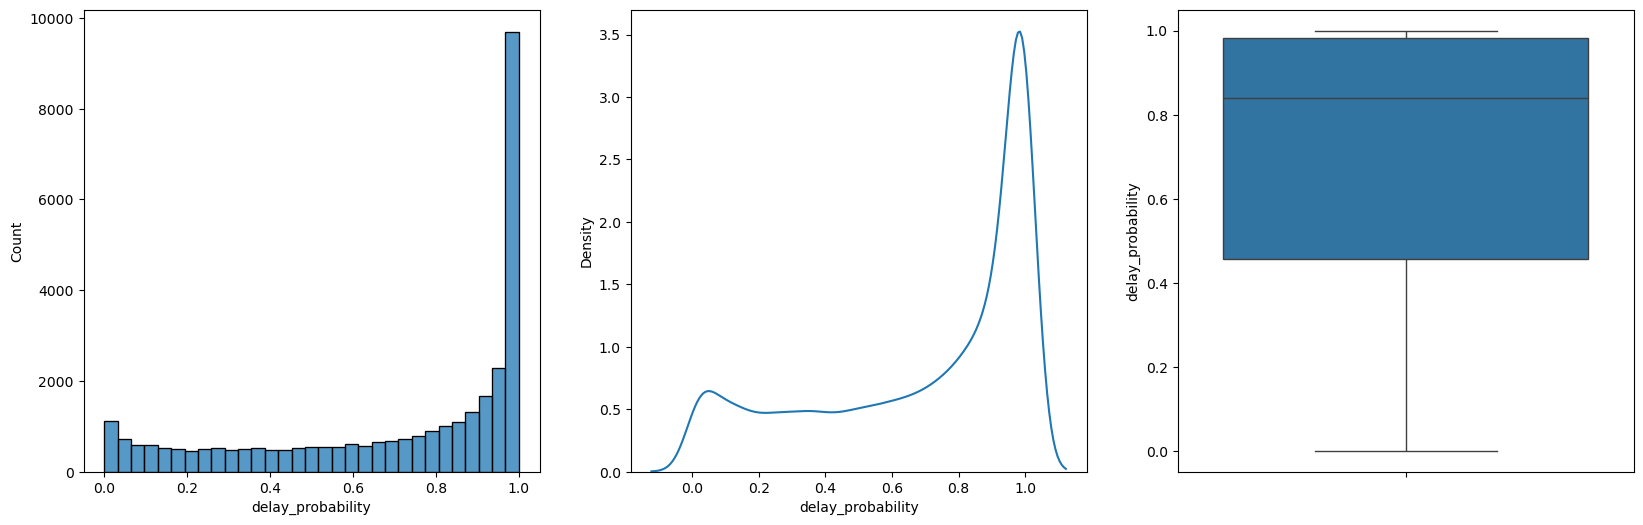

In [12]:
# Target Analysis

target_variable = 'delay_probability'

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(df[target_variable],ax=axs[0])
sns.kdeplot(df[target_variable],ax=axs[1])
sns.boxplot(df[target_variable], ax=axs[2])

plt.show()

**Brief conclusion:** The number of shipments in the high delay probability bin is significantly higher than in the others, indicating an imbalance in the data.

#### Float Feature Variables: Employ histograms to understand the central tendency, spread, and shape of the variables' distribution.

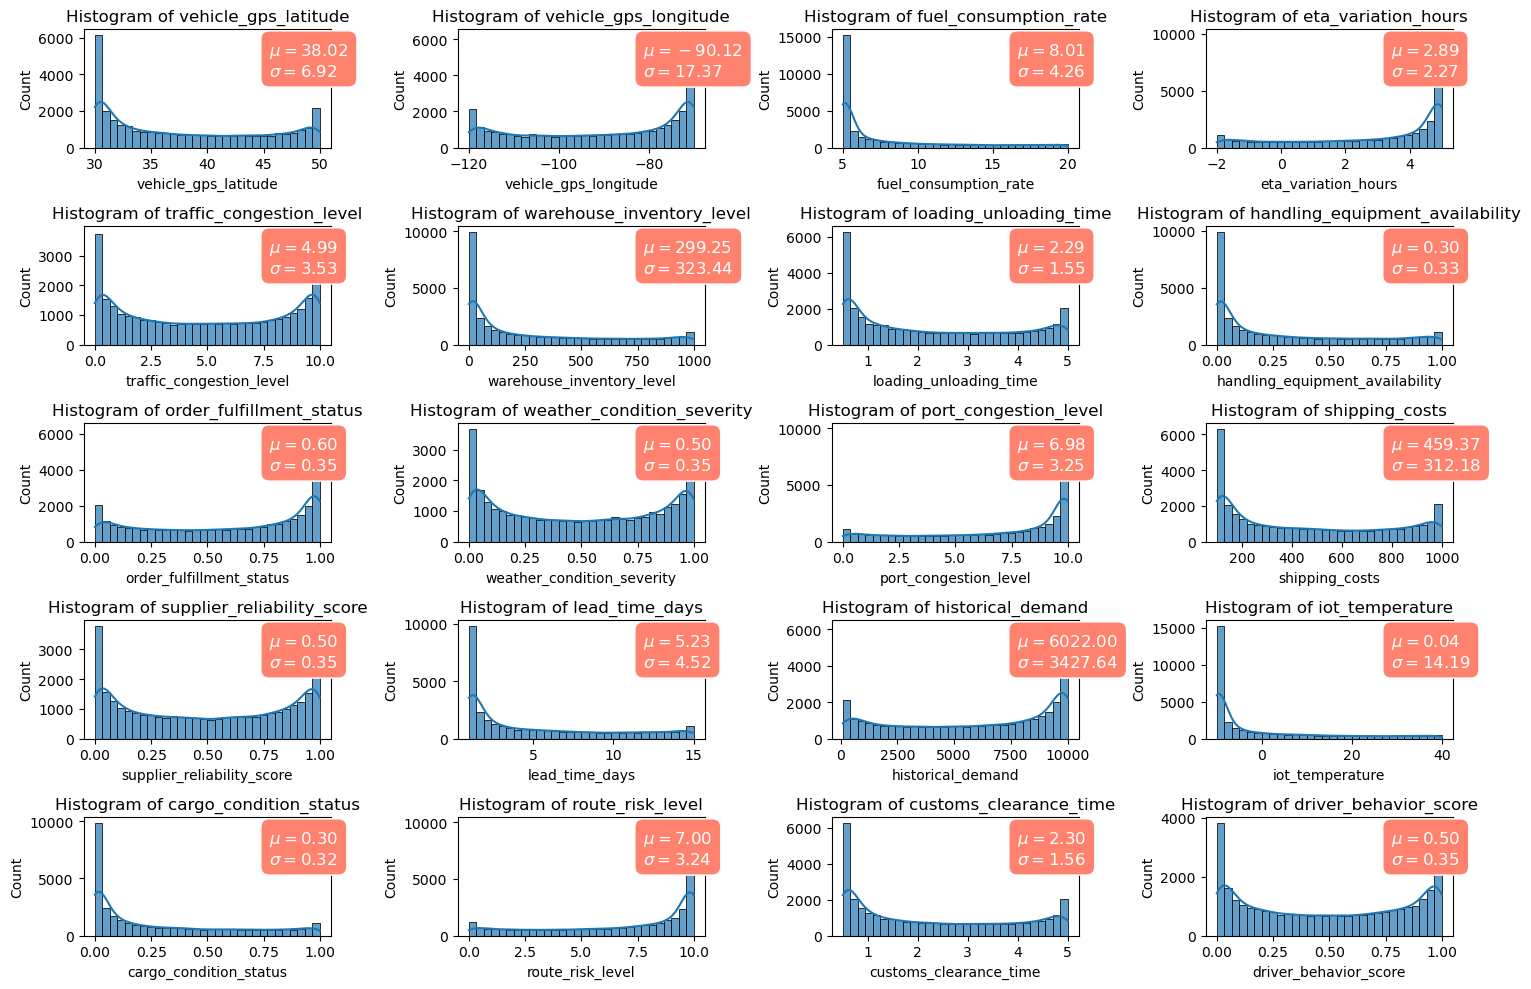

In [14]:
# Đánh giá phân bổ của các continous features 

float_variables = [col for col in df.select_dtypes(include=['float64']).columns.tolist()]
float_variables_df = df[float_variables]

float_feature_variables = [
    col for col in df.select_dtypes(include=['float64']).columns.tolist()
    if col not in ['delay_probability']
]
float_feature_variables_df = df[float_feature_variables]

plt.figure(figsize=(15, 10))

for i, col in enumerate(float_feature_variables):
    if i < 20:
        plt.subplot(5, 4, i + 1)
        sns.histplot(df[col], kde=True, bins=30, alpha=0.7)

        plt.title(f'Histogram of {col}')
        plt.text(
            0.75, 0.9, 
            fr"$\mu={df[col].mean():.2f}$" "\n" fr"$\sigma={df[col].std():.2f}$", 
            transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='white',
            bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5)
        )

        plt.grid(False)

plt.tight_layout()
plt.show()

In [18]:
skewness = float_feature_variables_df.skew()

positive_skew_columns = skewness[skewness > 0].index.tolist()
negative_skew_columns = skewness[skewness < 0].index.tolist()

print(skewness)
print("Columns with positive skewness:", positive_skew_columns)
print("Columns with negative skewness:", negative_skew_columns)

vehicle_gps_latitude               0.383415
vehicle_gps_longitude             -0.372547
fuel_consumption_rate              1.415944
eta_variation_hours               -0.819834
traffic_congestion_level           0.007640
warehouse_inventory_level          0.827780
loading_unloading_time             0.390971
handling_equipment_availability    0.808054
order_fulfillment_status          -0.385854
weather_condition_severity         0.008677
port_congestion_level             -0.813453
shipping_costs                     0.387397
supplier_reliability_score        -0.008788
lead_time_days                     0.807769
historical_demand                 -0.376473
iot_temperature                    1.405043
cargo_condition_status             0.835135
route_risk_level                  -0.827798
customs_clearance_time             0.385924
driver_behavior_score              0.002583
fatigue_monitoring_score          -0.389966
dtype: float64
Columns with positive skewness: ['vehicle_gps_latitude', 'fue

**The distribution of all features in dataset has 2 kind: skewed or U-shaped distribution.**

**1, U-Shaped Distribution**

A U-Shaped distribution is a bimodal distribution with frequencies that steadily fall and then steadily rise. There is a higher chance of a measurement being found at the extremes than in the center of the distribution. 
In some ways, this distribution can be thought of as an upside down bell curve. However, a U-shaped distribution can’t be turned into a bell curve by a meaningful transformation, even if it is perfectly symmetric (Iversen & Norpoth, 1987).

A symmetric U-shaped distribution has the following characteristics:

- Tails are equal on both sides.
- Coefficient of skewness is zero.
- The mean is less than the highest mode.
- The mean is equal to the median.
- Quartiles are defined as (Q3 – Md) = Md – Q1). In other words, the difference between the third quartile and the median equals the difference between the first quartile and the median.

In machine learning, non-linear tree-based models (e.g., XGBoost, Random Forest) handle U-shaped distributions better than linear models.

**2, Skewness**

All features show skewness. We need some transformation to normal the features:
- Positively Skewed Features: Some transformation technique should apply:
  + Log Transformation: Effectively minimizing large-scale differences by taking the natural log of all data points.
  + Square Root Transformation: A softer approach than the log transformation, ideal for moderately skewed data.
  + Box-Cox Transformation: Optimizing the transformation parameter lambda (λ), applicable only to positive data.
  + Yeo-Johnson Transformation: Similar to Box-Cox but adaptable to both positive and non-positive data.
  + Quantile transformation: Maps data to a specified distribution, such as normal, effectively addresses skewness by distributing the data points evenly across the chosen distribution. This transformation normalizes the shape of the data, focusing on making the distribution more uniform or Gaussian-like without assuming it will directly benefit linear models due to its non-linear nature and the challenge of reverting the data to its original form.

- Negatively Skewed Features: Some transformation technique should apply:
  + Power Transformations: Distributions that are left skew may be made more symmetric by taking a power (greater than 1), or by exponentiating. If it has an obvious upper bound, one might subtract observations from the upper bound (giving a right skewed result) and then attempt to transform that.
  + Squared Transformation: Taking each data point in the dataset and squaring it (i.e., raising it to the power of 2), useful for reducing negative skewness because it tends to spread out the lower values more than the higher values. However, it’s more effective when all data points are positive and the degree of negative skewness is not extreme.
  + Cubed Transformation: Similar to the squared transformation but involves raising each data point to the power of 3.
  + Box-Cox Transformation: A more sophisticated method that finds the best lambda (λ) parameter to transform the data into a normal shape.
  + Yeo-Johnson Transformation: Similar to the Box-Cox transformation, but the Yeo-Johnson is designed to handle both positive and negative data.
  + Quantile Transformation: This method transforms the features to follow a specified distribution, such as the normal distribution, based on their quantiles. It does not assume any specific distribution shape for the input data.
  
**Reference:**

- https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists
- https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distributionstribution

#### Object Feature Variables: Extract date-related features and time-series visualization

In [185]:
# Transform trường timestamp thành các giá trị thời gian khác như month, day, date, weekday,... để phân tích data có time-depedent không
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['date'] = df['timestamp'].dt.date
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holidays.UnitedStates() else 0)

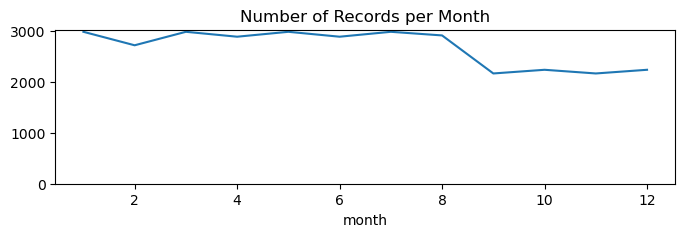

In [234]:
# Phân bổ dữ liệu theo tháng
date_counts = df.groupby('month').size()

plt.figure(figsize=(8, 2))
date_counts.plot(kind='line')

plt.title("Number of Records per Month")
plt.ylim(bottom=0)

plt.show()

In [36]:
total_records = len(df)
jan_to_aug_pct = (df['month'].between(1, 8).mean() * 100).round(2)
sep_to_dec_pct = (100 - jan_to_aug_pct).round(2)

jan_to_aug_pct, sep_to_dec_pct

(72.61, 27.39)

The dataset contains a high concentration of records from January to August, accounting for up to 72% of the total records.

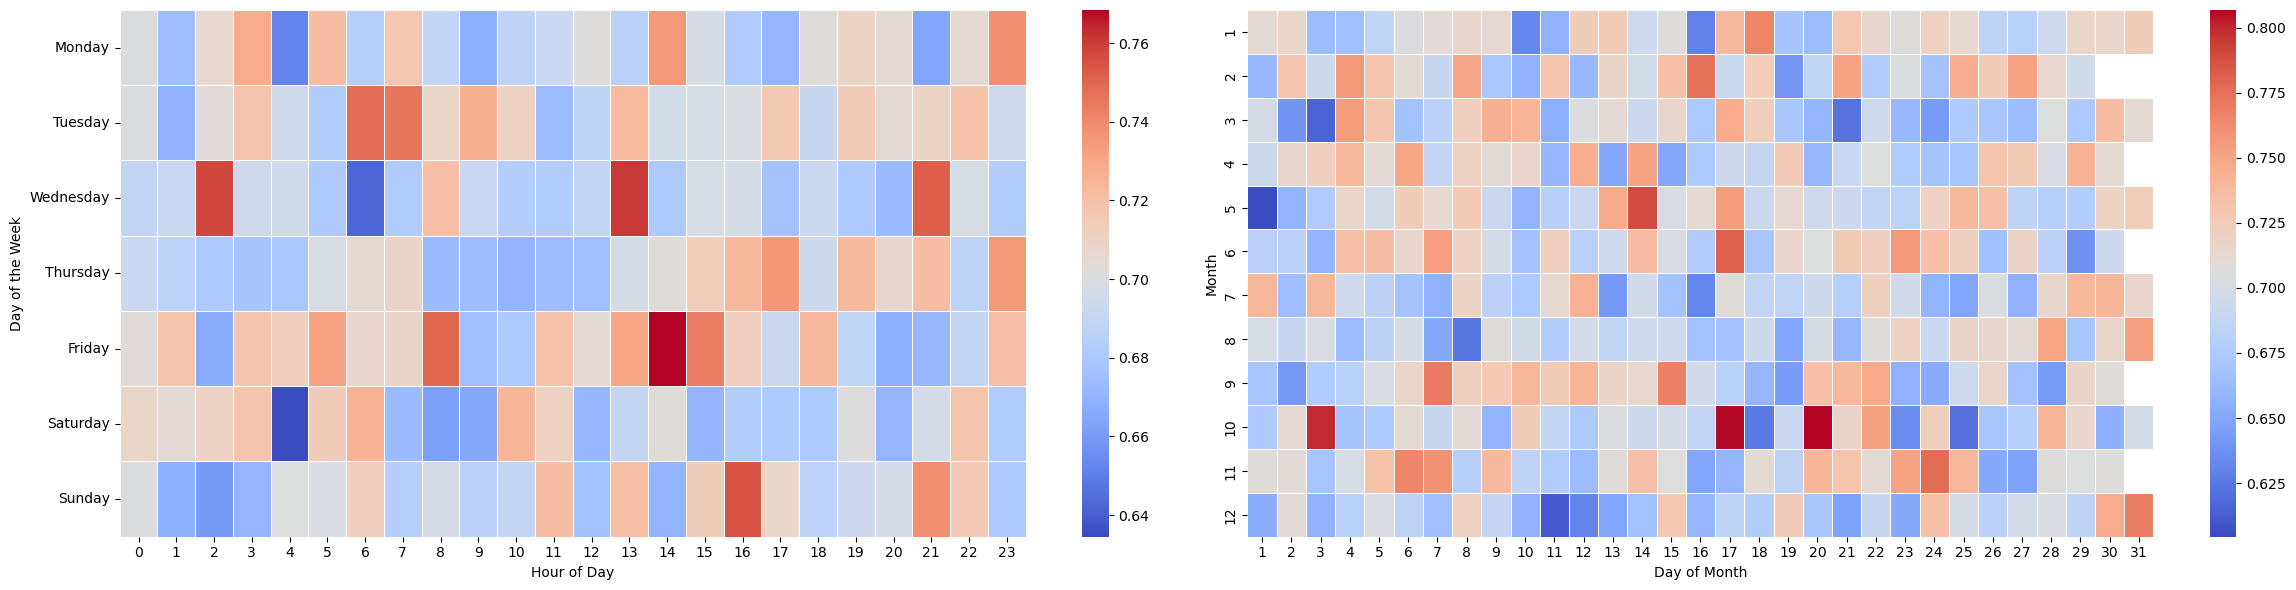

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

### Heatmap 1: Đánh giá liệu có ý nghĩa tương quan nào giữa giờ giao và ngày trong tuần với xác suất đơn hàng bị delay không
heatmap_data1 = df.pivot_table(index="weekday", columns="hour", values="delay_probability")
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data1 = heatmap_data1.reindex(day_order)
sns.heatmap(heatmap_data1, cmap="coolwarm", annot=False, linewidths=0.5, ax=axes[0])
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Day of the Week")

### Heatmap 2: Đánh giá liệu có ý nghĩa tương quan nào giữa ngày trong tháng và tháng với xác suất đơn hàng bị delay không
heatmap_data2 = df.pivot_table(index="month", columns="day", values="delay_probability")
sns.heatmap(heatmap_data2, cmap="coolwarm", annot=False, linewidths=0.5, ax=axes[1])
axes[1].set_xlabel("Day of Month")
axes[1].set_ylabel("Month")

plt.tight_layout()
plt.show()

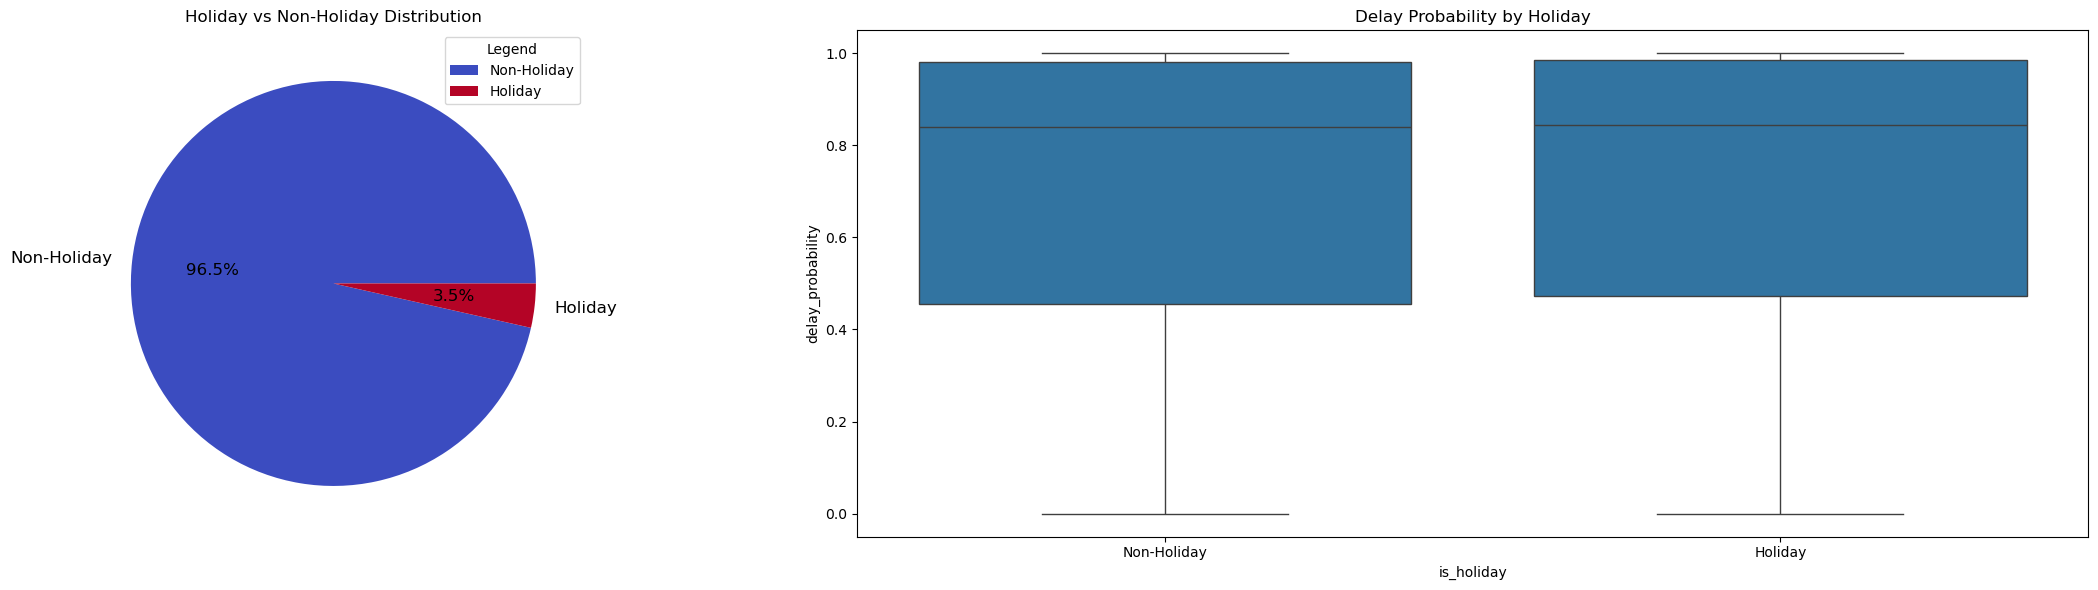

In [229]:
# Đánh giá liệu có ý nghĩa tương quan nào giữa ngày lễ với xác suất đơn hàng bị delay không
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

df['is_holiday'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['Non-Holiday', 'Holiday'], 
    colors=colors, 
    textprops={'color': 'black', 'size': 12}, 
    ax=axes[0]
)
axes[0].set_ylabel('')
axes[0].set_title("Holiday vs Non-Holiday Distribution")
axes[0].legend(['Non-Holiday', 'Holiday'], title="Legend", loc="upper right")

sns.boxplot(x='is_holiday', y='delay_probability', data=df, ax=axes[1])
axes[1].set_title('Delay Probability by Holiday')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Holiday', 'Holiday'])

plt.tight_layout()
plt.show()

**Brief conclusion:** There does not appear to be any relationship between the timestamp and the delay probability.

### Bivariate Analysis


The correlation analysis should typically be performed before any other data preprocessing steps, such as balancing or scaling the data. This is because the correlation analysis is used to identify relationships between variables in the dataset, which can then be used to guide the selection of features and the development of the predictive model.

Performing the correlation analysis after scaling or balancing the data may result in a distorted view of the relationships between variables, as these preprocessing steps can change the distribution of the data. Therefore, it is generally recommended to perform the correlation analysis before any other data preprocessing steps.

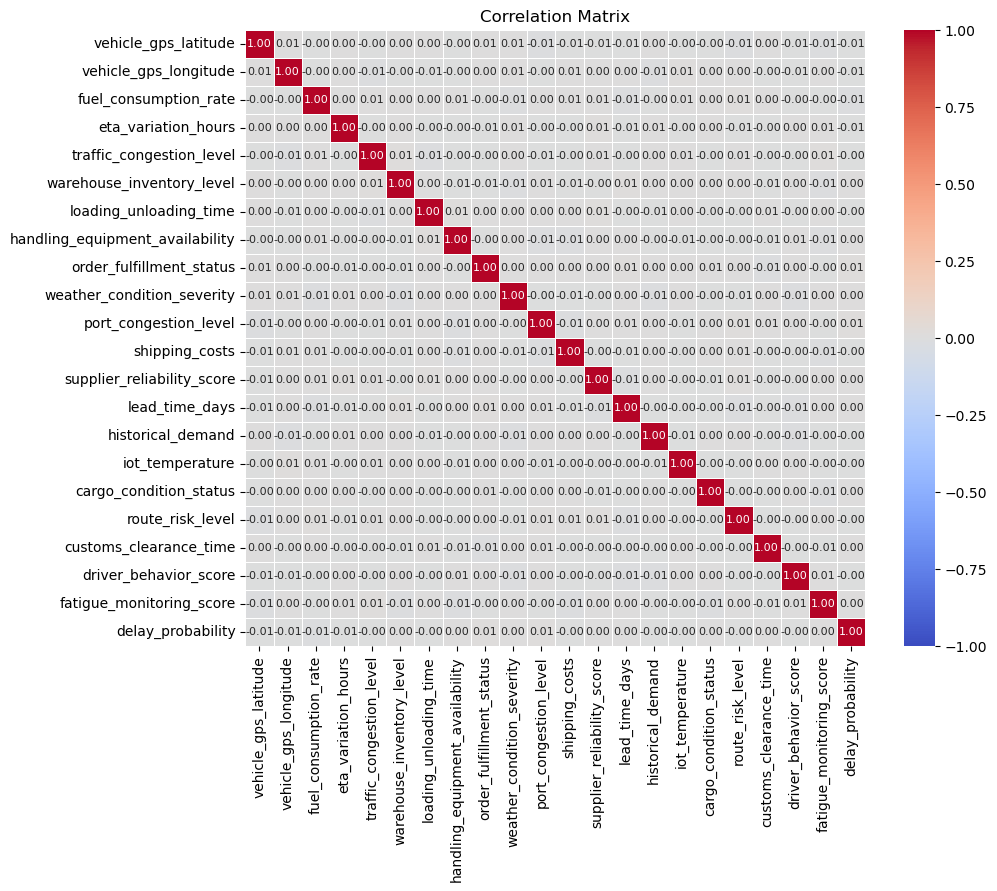

In [242]:
# Đánh giá tương quan giữa các biến đầu vào với nhau và với biến phụ thuộc

corr = float_variables_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Correlation Matrix')
plt.show()

In [43]:
corr['delay_probability'].sort_values()

fuel_consumption_rate             -0.013655
eta_variation_hours               -0.006897
vehicle_gps_latitude              -0.006185
vehicle_gps_longitude             -0.005691
driver_behavior_score             -0.003919
traffic_congestion_level          -0.003790
route_risk_level                  -0.003407
historical_demand                 -0.002907
iot_temperature                   -0.001139
loading_unloading_time            -0.000706
shipping_costs                    -0.000280
fatigue_monitoring_score           0.001070
lead_time_days                     0.001083
weather_condition_severity         0.001503
supplier_reliability_score         0.001890
handling_equipment_availability    0.002690
cargo_condition_status             0.002910
warehouse_inventory_level          0.004686
customs_clearance_time             0.004896
port_congestion_level              0.008972
order_fulfillment_status           0.009730
delay_probability                  1.000000
Name: delay_probability, dtype: 

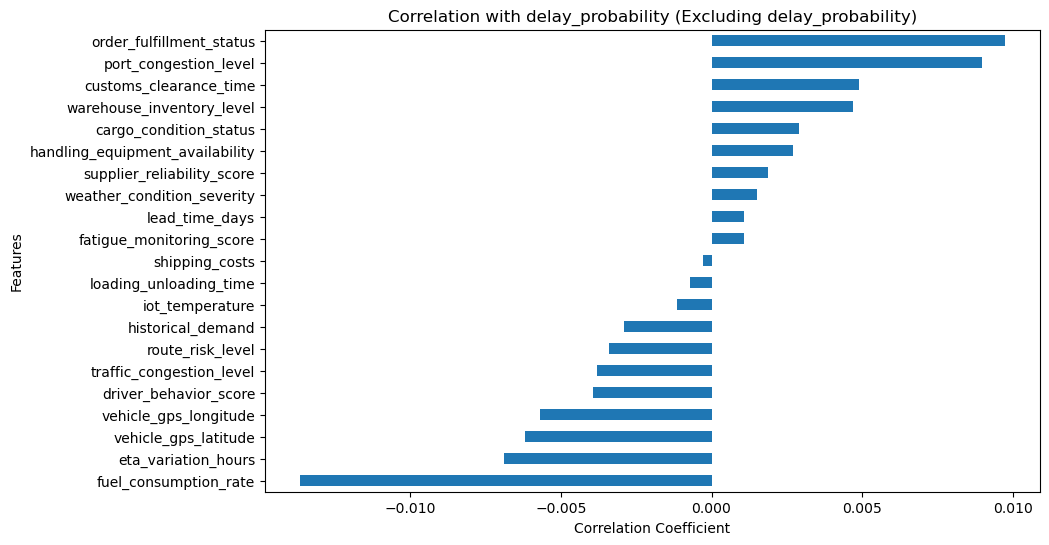

In [44]:
plt.figure(figsize=(10, 6))
corr['delay_probability'].drop('delay_probability').sort_values().plot(kind='barh')
plt.title('Correlation with delay_probability (Excluding delay_probability)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [266]:
from scipy.stats import pearsonr

def pearson_r_python(list1, list2):
    correlation, p_value = pearsonr(list1, list2)
    return correlation, p_value

results = []
for column in float_variables_df.columns:
    correlation, p_value = pearson_r_python(float_variables_df[column], df['delay_probability'])
    results.append([column, correlation, p_value])
results_df = pd.DataFrame(results, columns=['Column', 'Correlation', 'P-value'])

results_df.sort_values(by='P-value')

,Column,Correlation,P-value
21,delay_probability,1.0000,0.0000
2,fuel_consumption_rate,-0.0137,0.0145
8,order_fulfillment_status,0.0097,0.0815
10,port_congestion_level,0.0090,0.1081
3,eta_variation_hours,-0.0069,0.2169
0,vehicle_gps_latitude,-0.0062,0.2681
1,vehicle_gps_longitude,-0.0057,0.3082
18,customs_clearance_time,0.0049,0.3807
5,warehouse_inventory_level,0.0047,0.4014
19,driver_behavior_score,-0.0039,0.4829


**Brief conclusion:**
There is a very weak negative linear relationship between fuel_consumption_rate and delay_probability. The relationship is statistically significant (since the p-value is below 0.05), but the correlation is so small that its practical impact is likely negligible. The rest, the correlation values are very close to 0 and p-value is > 0.05, suggesting that there is virtually no significant linear relationship between the variables.

There is non-linear correlation models time to shine.